In [1]:
import pandas as pd

# Adjust the file paths if they’re not in the same folder as your notebook
account_district_2024 = pd.read_csv('AccountDistrict2024.csv')
porg_account_2021_2025 = pd.read_csv('PorgAccount20212025.csv')
historic_debt_profile = pd.read_csv('HistoricDebtProfile.csv')

# Quick peek at each
print(account_district_2024.head())
print(porg_account_2021_2025.head())
print(historic_debt_profile.head())


   pk_district  pk_account  description
0           52    30097144  Warrnambool
1           93    30028490     Portland
2           52    10004000  Warrnambool
3            7    30030924     Hamilton
4           32    10017963       Koroit
   pk_porg  pk_account  fk_financial_year
0      116    30007505             202425
1      120    10000019             202425
2      122    10000021             202425
3      123    10000022             202425
4      124    10005311             202425
   fk_financial_year  month  pk_porg  pk_account pension_type_desc  amt_debit
0             201718     12   121488    30084795   Social Security       0.95
1             201920     12    55628    30059774   Social Security       0.00
2             202122     12   124737    30099129   Social Security      74.90
3             201920     12    73972    30088800   Social Security     178.91
4             201718     12     2704    10003327   Social Security     171.72


In [2]:
# as string-slice
historic_debt_profile['calendar_year'] = (
    historic_debt_profile['fk_financial_year']
    .astype(str)
    .str[:4]
    .astype(int)
)


In [4]:
# 1. Structure and non-null counts
historic_debt_profile.info()

# 2. Summary statistics for numeric columns
historic_debt_profile.describe()

# 3. Summary statistics for everything (including strings/dates)
historic_debt_profile.describe(include='all')

# 4. See the first few rows to get a feel for the data
historic_debt_profile.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41067 entries, 0 to 41066
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   fk_financial_year  41067 non-null  int64  
 1   month              41067 non-null  int64  
 2   pk_porg            41067 non-null  int64  
 3   pk_account         41067 non-null  int64  
 4   pension_type_desc  39445 non-null  object 
 5   amt_debit          41067 non-null  float64
 6   calendar_year      41067 non-null  int32  
dtypes: float64(1), int32(1), int64(4), object(1)
memory usage: 2.0+ MB


,fk_financial_year,month,pk_porg,pk_account,pension_type_desc,amt_debit,calendar_year
0,201718,12,121488,30084795,Social Security,0.95,2017
1,201920,12,55628,30059774,Social Security,0.00,2019
2,202122,12,124737,30099129,Social Security,74.90,2021
3,201920,12,73972,30088800,Social Security,178.91,2019
4,201718,12,2704,10003327,Social Security,171.72,2017


In [6]:
# 1. (Optional) rename columns for clarity
ad = account_district_2024.rename(
    columns={'AccountNo': 'pk_account', 'DistrictDescription': 'description'}
)
pa = porg_account_2021_2025.rename(
    columns={'AccountNo': 'pk_account'}  # add more renames if needed
)

# 2. Merge historic_debt_profile → porg_account → account_district
merged = (
    historic_debt_profile
      .merge(pa[['pk_account']], on='pk_account', how='left')
      .merge(ad[['pk_account', 'description']], on='pk_account', how='left')
)

# 3. Quick sanity‐check
print(merged[['pk_account', 'description']].drop_duplicates().head())


   pk_account  description
0    30084795          NaN
1    30059774  Warrnambool
2    30099129          NaN
3    30088800          NaN
4    10003327  Warrnambool


In [8]:
# 1. Structure & non-null counts
merged.info()

# 2. Summary stats for numeric columns
merged.describe()

# 3. Summary stats for all columns (incl. object types)
merged.describe(include='all')

# 4. Peek at the first few rows
merged.head()

# 5. Check how many districts failed to join
merged['description'].isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41080 entries, 0 to 41079
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   fk_financial_year  41080 non-null  int64  
 1   month              41080 non-null  int64  
 2   pk_porg            41080 non-null  int64  
 3   pk_account         41080 non-null  int64  
 4   pension_type_desc  39458 non-null  object 
 5   amt_debit          41080 non-null  float64
 6   calendar_year      41080 non-null  int32  
 7   description        35339 non-null  object 
dtypes: float64(1), int32(1), int64(4), object(2)
memory usage: 2.4+ MB


5741

In [12]:
# Option A: prints an Index of column names
print(merged.columns)

# Option B: gives you a plain Python list
merged.columns.tolist()


Index(['fk_financial_year', 'month', 'pk_porg', 'pk_account',
       'pension_type_desc', 'amt_debit', 'calendar_year', 'district'],
      dtype='object')


['fk_financial_year',
 'month',
 'pk_porg',
 'pk_account',
 'pension_type_desc',
 'amt_debit',
 'calendar_year',
 'district']

In [10]:
# 1. Average debt per calendar year
avg_per_year = (
    merged
    .groupby('calendar_year')['amt_debit']
    .mean()
    .reset_index(name='avg_debt')
)

# 2. Overall average debt for the whole dataset
overall_avg = merged['amt_debit'].mean()

# 3. Display results
print(avg_per_year)
print(f"\nOverall average debt: {overall_avg:.2f}")


   calendar_year    avg_debt
0           2017   98.926732
1           2018  105.588751
2           2019   91.496929
3           2020   93.210947
4           2021   91.955030
5           2022   86.495069
6           2023  103.511510
7           2024  128.390465

Overall average debt: 100.43


In [11]:
merged = merged.rename(columns={'description': 'district'})


In [13]:
# 1. Filter for 2024
debt_2024 = merged[merged['calendar_year'] == 2024]

# 2. Sum debt by district and pick top 10
top10_districts = (
    debt_2024
    .groupby('district')['amt_debit']
    .sum()
    .nlargest(10)
    .reset_index(name='total_debt')
)

# 3. See the result
print(top10_districts)


      district  total_debt
0  Warrnambool   247318.72
1     Hamilton   119233.06
2    Casterton    83214.25
3     Portland    57529.55
4    Coleraine    53367.11
5       Koroit    30899.35
6      Dunkeld    19162.70
7   Camperdown    13326.41
8     Mortlake    12200.28
9    Penshurst    11800.66


In [16]:
# 1. Filter for 2024
debt_2024 = merged[merged['calendar_year'] == 2024]

# 2. Aggregate total and average debt per district
agg = (
    debt_2024
    .groupby('district')['amt_debit']
    .agg(total_debt='sum', avg_debt='mean')
    .sort_values('total_debt', ascending=False)
    .head(10)
    .reset_index()
)

agg['avg_debt'] = agg['avg_debt'].round(2)


# 3. Show the result
print(agg)


      district  total_debt  avg_debt
0  Warrnambool   247318.72    132.11
1     Hamilton   119233.06    135.65
2    Casterton    83214.25    285.96
3     Portland    57529.55     78.38
4    Coleraine    53367.11    224.23
5       Koroit    30899.35    165.24
6      Dunkeld    19162.70    220.26
7   Camperdown    13326.41     62.57
8     Mortlake    12200.28    125.78
9    Penshurst    11800.66    129.68


In [17]:
# 1. Filter for 2024
debt_2024 = merged[merged['calendar_year'] == 2024]

# 2. Aggregate total and average debt per district
agg = (
    debt_2024
    .groupby('district')['amt_debit']
    .agg(total_debt='sum', avg_debt='mean')
    .sort_values('avg_debt', ascending=False)
    .head(10)
    .reset_index()
)

agg['avg_debt'] = agg['avg_debt'].round(2)


# 3. Show the result
print(agg)


            district  total_debt  avg_debt
0          Casterton    83214.25    285.96
1             Purnim     3461.79    266.29
2          Coleraine    53367.11    224.23
3            Dunkeld    19162.70    220.26
4             Merino    11519.73    213.33
5  Willaura Pipeline      423.02    211.51
6         Allansford     8310.80    169.61
7             Koroit    30899.35    165.24
8           Hamilton   119233.06    135.65
9         Tarrington     2831.12    134.82


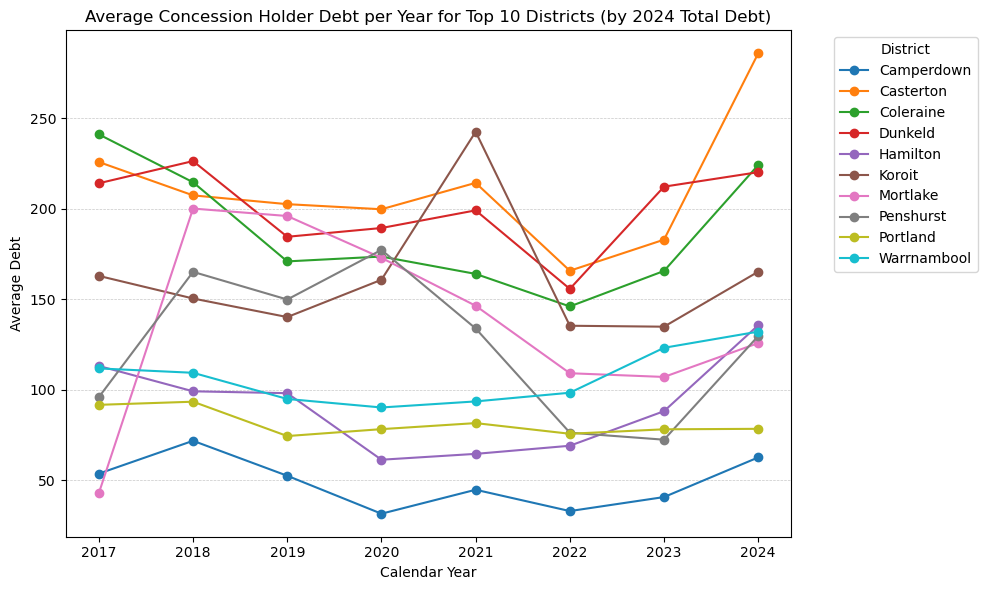

In [25]:
# 4. Identify top 10 districts by total debt for 2024
debt_2024 = merged[merged['calendar_year'] == 2024]
top10 = debt_2024.groupby('district')['amt_debit'].sum().nlargest(10).index.tolist()

# 5. Compute average debt per year for those top districts
avg_debt = (
    merged[merged['district'].isin(top10)]
    .groupby(['calendar_year', 'district'])['amt_debit']
    .mean()
    .reset_index()
)

# 6. Pivot so each district is its own column
pivot_df = avg_debt.pivot(index='calendar_year', columns='district', values='amt_debit')

# 7. Plot the line chart
ax = pivot_df.plot(
    figsize=(10, 6),
    marker='o'       # adds markers to lines for clarity
)
ax.set_xlabel('Calendar Year')
ax.set_ylabel('Average Debt')
ax.set_title('Average Concession Holder Debt per Year for Top 10 Districts (by 2024 Total Debt)')
ax.legend(title='District', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)

plt.tight_layout()
plt.show()


In [19]:
# 1. Filter for 2024
debt_2024 = merged[merged['calendar_year'] == 2024]

# 2. Compute average debt per town
avg_by_town = (
    debt_2024
    .groupby('district')['amt_debit']
    .mean()
    .nlargest(10)
    .reset_index(name='avg_debt')
)

# 3. (Optional) Round the averages for display
avg_by_town['avg_debt'] = avg_by_town['avg_debt'].round(2)

# 4. Show the result
print(avg_by_town)


            district  avg_debt
0          Casterton    285.96
1             Purnim    266.29
2          Coleraine    224.23
3            Dunkeld    220.26
4             Merino    213.33
5  Willaura Pipeline    211.51
6         Allansford    169.61
7             Koroit    165.24
8           Hamilton    135.65
9         Tarrington    134.82


district       Allansford  Casterton  Coleraine  Dunkeld  Hamilton  Koroit  \
calendar_year                                                                
2017               190.77     225.88     241.15   214.14    113.13  162.92   
2018               165.73     207.44     214.69   226.40     99.12  150.43   
2019               128.70     202.59     170.94   184.55     98.08  140.17   
2020               146.72     199.77     173.62   189.40     61.30  160.78   
2021               137.52     214.36     164.03   199.15     64.53  242.60   
2022               136.86     165.77     146.03   155.74     69.02  135.37   
2023               136.47     182.95     165.67   212.25     88.13  134.84   
2024               169.61     285.96     224.23   220.26    135.65  165.24   

district       Merino  Purnim  Tarrington  Willaura Pipeline  
calendar_year                                                 
2017            84.87   46.82       63.97              42.63  
2018            86.42   44.01 

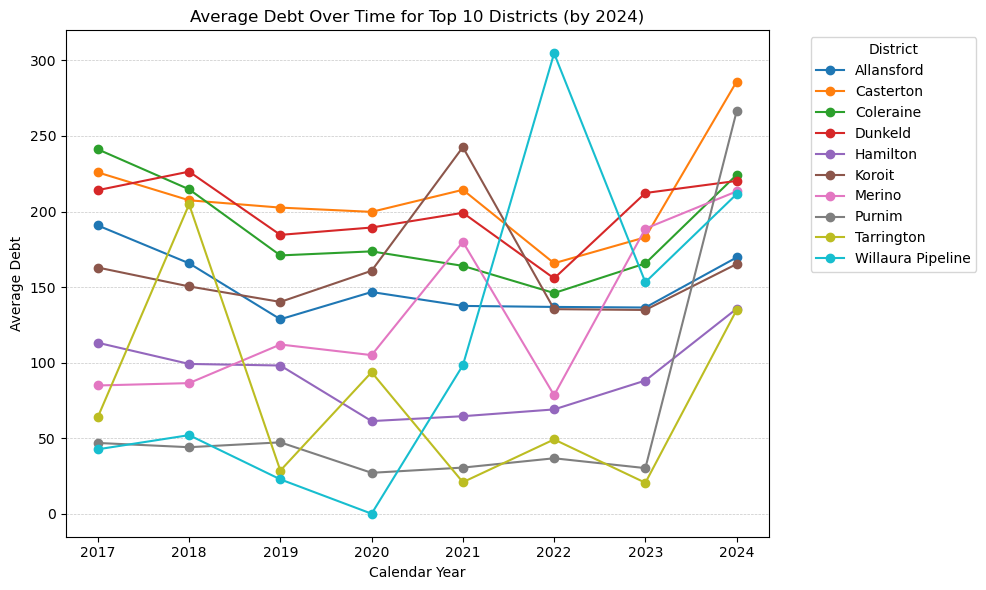

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Recompute the top 10 districts by avg debt in 2024
debt_2024 = merged[merged['calendar_year'] == 2024]
top10_districts = (
    debt_2024
    .groupby('district')['amt_debit']
    .mean()
    .nlargest(10)
    .index
    .tolist()
)

# 2. Calculate average debt per year for those districts
avg_over_time = (
    merged[merged['district'].isin(top10_districts)]
    .groupby(['calendar_year', 'district'])['amt_debit']
    .mean()
    .reset_index()
)

# 3. Pivot into a table: rows=year, columns=district
pivot_df = avg_over_time.pivot(
    index='calendar_year',
    columns='district',
    values='amt_debit'
)

# 4a. Display the table
print(pivot_df.round(2))

# 4b. (Optional) Plot the trends
fig, ax = plt.subplots(figsize=(10, 6))
pivot_df.plot(ax=ax, marker='o')

# Add light horizontal grid lines
ax.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)

ax.set_xlabel('Calendar Year')
ax.set_ylabel('Average Debt')
ax.set_title('Average Debt Over Time for Top 10 Districts (by 2024)')
ax.legend(title='District', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Average debt by district (overall):
district
Casterton            212.54
Dunkeld              202.07
Coleraine            191.45
Koroit               157.86
Allansford           152.63
Merino               127.84
Willaura Pipeline    124.80
Hamilton              94.08
Tarrington            88.60
Purnim                69.35
Name: amt_debit, dtype: float64

Highest overall average debt: Casterton with $212.54
